# <center> Сегментация клиентов банка

<center> <img src=https://lms-cdn.skillfactory.ru/assets/courseware/v1/74038139a886991d7d5432cdbc737027/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/MATHML_md10_7_1.jpg
align="right" width="300"/> </center>

В нашем распоряжении есть [данные](https://lms-cdn.skillfactory.ru/assets/courseware/v1/19c4fca978e965957f2f15ccee9523e6/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/CC_GENERAL.zip) о 8950 держателях кредитных карт одного из банков Нью-Йорка. Банк собрал достаточно много данных об этих людях и о том, как они пользовались кредитными картами за последние полгода.

Маркетологи хотят запустить рекламную кампанию, однако для этого необходимо произвести сегментацию клиентов, чтобы сделать акционное предложение более персонализированным. Мы попробуем использовать все известные нам методы кластеризации и посмотрим на получившиеся результаты.

In [1]:
# Загрузим библиотеки
# Для работы с таблицами и числами
import pandas as pd
import numpy as np
# Для моделирования
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
# Для графики и отображения
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8')
# Подавление предупреждений
import warnings
warnings.filterwarnings('ignore')


Информация о клиентах

|feature|description|feature|description|
|-|-|-|-|
|`CUST_ID`|идентификационный номер держателя карты|`CASHADVANCEFREQUENCY`|частота внесения авансовых платежей|
|`BALANCE`|баланс, доступный для совершения покупок|`CASHADVANCETRX`|количество транзакций с авансовыми взносами|
|`BALANCEFREQUENCY`|как часто обновляется показатель баланса (1 — часто, 0 — нечасто)|`PURCHASESTRX`|количество совершённых транзакций с покупками|
|`PURCHASES`|количество покупок, оплаченных со счёта|`CREDITLIMIT`|кредитный лимит держателя карты|
|`ONEOFFPURCHASES`|максимальная сумма единовременной покупки|`PAYMENTS`|сумма платежей пользователя|
|`INSTALLMENTSPURCHASES`|сумма покупок, сделанных в рассрочку|`MINIMUM_PAYMENTS`|сумма минимального платежа пользователя|
|`PURCHASESFREQUENCY`|как часто в целом совершаются покупки (1 — часто, 0 — нечасто)|`PRCFULLPAYMENT`|выплаченный процент от полного платежа|
|`ONEOFFPURCHASESFREQUENCY`|частота совершения единовременных покупок (1 — часто, 0 — нечасто)|`TENURE`|срок обслуживания кредитной карты|
|`PURCHASESINSTALLMENTSFREQUENCY`|частота совершения покупок в рассрочку (1 — часто, 0 — нечасто)|||


## Загрузка и подготовка данных

In [2]:
cc_df = pd.read_csv('data/CC_GENERAL.zip')
print(f'Размер таблицы датасета: {cc_df.shape[0]} строк, {cc_df.shape[1]} столбцов.')
cc_df.head()


Размер таблицы датасета: 8950 строк, 18 столбцов.


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


Приступим к анализу данных. Начнём его с проверки данных на наличие пропущенных значений.

In [3]:
cc_df.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

### Заполнение пропусков

Заполним все пропуски средними арифметическими для признаков.

In [4]:
cc_df['CREDIT_LIMIT'] = cc_df['CREDIT_LIMIT'].fillna(cc_df['CREDIT_LIMIT'].mean())
cc_df['MINIMUM_PAYMENTS'] = cc_df['MINIMUM_PAYMENTS'].fillna(cc_df['MINIMUM_PAYMENTS'].mean())

Также предварительно удалим признак CUST_ID — он не поможет при кластеризации, так как не несёт никакой содержательной информации.

In [5]:
X = cc_df.drop('CUST_ID', axis=1)

### Анализ корреляций

Число столбцов: 17
Ранг матрицы:   17
Определитель:   3.606605094427088e-09


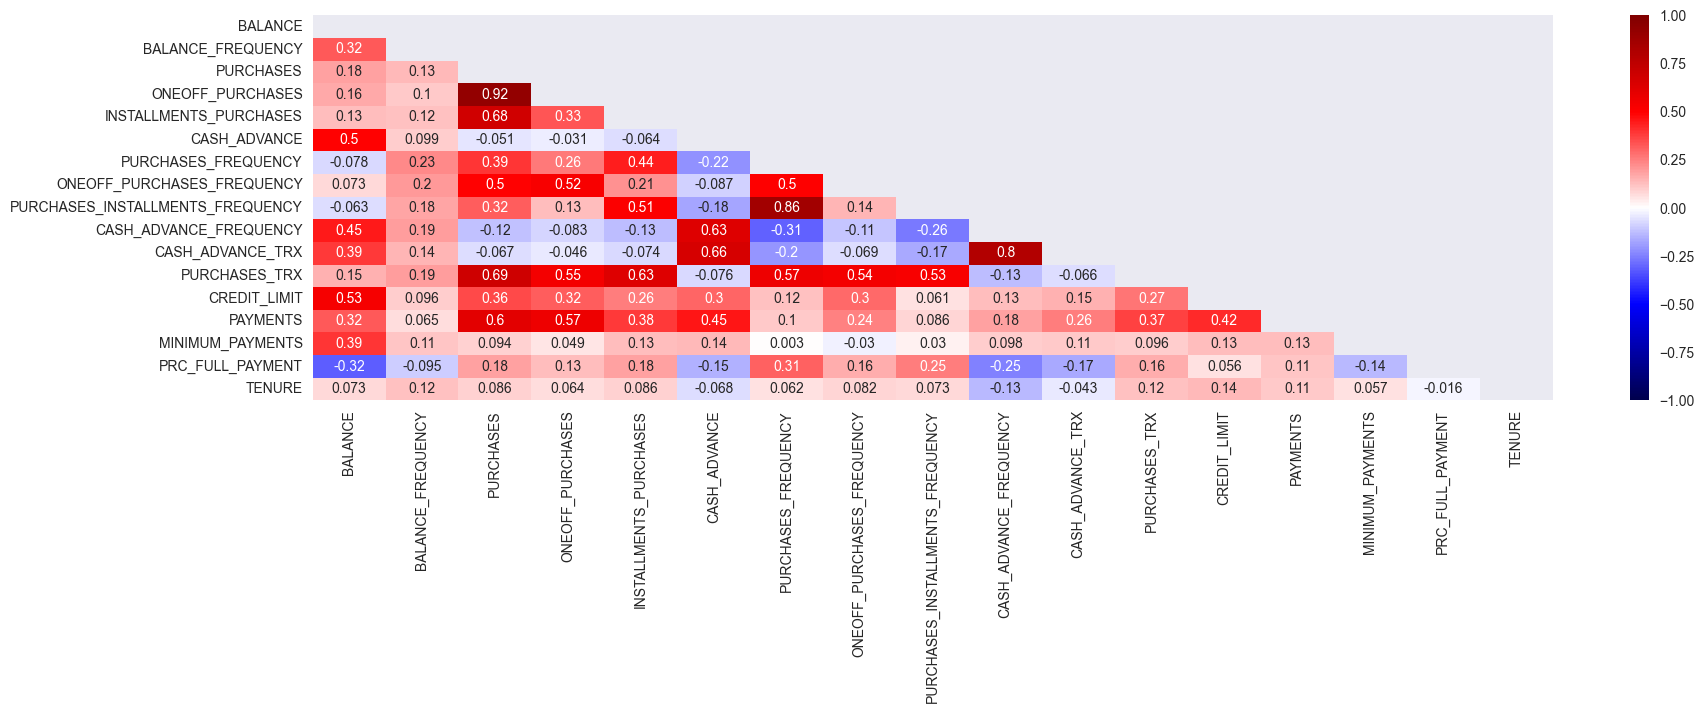

In [6]:
# Матрица корреляций
X_corr = X.corr()
# Выведем тепловую карту на основе матрицы корреляций
matrix = np.triu(X_corr) # Треугольная маска
fig, axes = plt.subplots(figsize=(20, 5))
# Тепловая карта
sns.heatmap(
    X_corr, vmin=-1, vmax=1, cmap='seismic',
    annot=True, mask=matrix, ax=axes
);
# Параметры матрицы
print('Число столбцов:', X_corr.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(X_corr))
print('Определитель:  ', np.linalg.det(X_corr))

Число столбцов равно рангу, значит можно считать, что признаки формально являются линейно независимыми. Однако определитель матрицы корреляций практически нулевой, что свидетельствует о наличии мультиколлинеарности: целесообразно будет применить метод главных компонент.

In [7]:
# Определяем метод таким образом, чтобы отобранные им
# компоненты объясняли не менее 99 % разброса данных
pca = PCA(n_components=0.99)
# Обучаем алгоритм на наших данных
prncplCmpnnts = pca.fit_transform(X)
print(f'Число компонент: {len(prncplCmpnnts[0])}')

Число компонент: 7


Для наглядности отобразим матрицу корреляций получившегося массива.

Число столбцов: 7
Ранг матрицы:   7
Определитель:   1.0


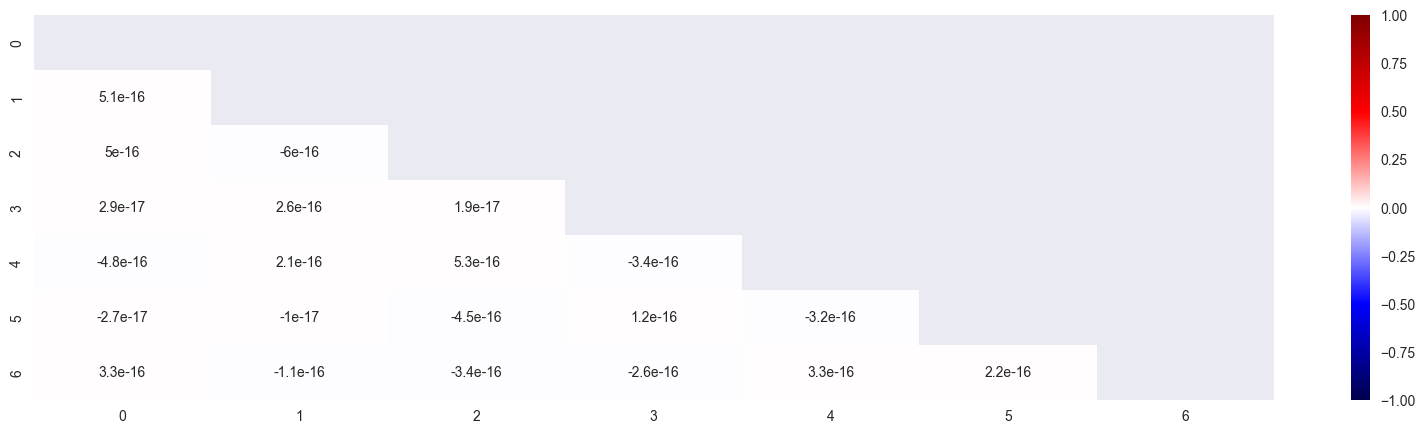

In [8]:
# Матрица корреляций
corr_mtrx = pd.DataFrame(data=prncplCmpnnts, columns=list(range(7))).corr()
# Выведем тепловую карту на основе матрицы корреляций
matrix = np.triu(corr_mtrx) # Треугольная маска
fig, axes = plt.subplots(figsize=(20, 5))
# Тепловая карта
sns.heatmap(
    corr_mtrx, vmin=-1, vmax=1, cmap='seismic',
    annot=True, mask=matrix, ax=axes
);
# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
print('Определитель:  ', np.linalg.det(corr_mtrx))

Она вся белая, определитель равен единице: все вектора-признаки ортогональны друг другу.

### Нормализация данных

Теперь нормализуем данные с помощью StandardScaler.

In [9]:
scaler = StandardScaler()
pC_norm = scaler.fit_transform(prncplCmpnnts)

## Моделирование

### KMeans

Теперь можем приступать к кластеризации. Начнём с самого простого и популярного метода — k-means. Для того чтобы его применить, необходимо узнать число кластеров. Наилучший способ сделать это — применить коэффициент силуэта. Найдем с его помощью оптимальное количество кластеров, перебрав диапазон от 2 до 9 включительно.

In [10]:
silhouette, calinski_harabasz, davies_bouldin = dict(), dict(), dict()
# Проходимся циклом по всем нужным нам значениям количества кластеров
for n in range(2, 10):
	# Обучаем модель k-means с текущим количеством кластеров
    km = KMeans(n_clusters=n, n_init=10, random_state=42).fit(pC_norm)
	# Выводим результат для коэффициента силуэта
    silhouette[n] = silhouette_score(pC_norm, km.labels_, metric='euclidean')
    calinski_harabasz[n] = calinski_harabasz_score(pC_norm, km.labels_)
    davies_bouldin[n] = davies_bouldin_score(pC_norm, km.labels_)

n_kl_silh = sorted(silhouette, key=lambda x: silhouette[x], reverse=True)[0]
print(f'Число кластеров с оптимальным коэффициентом силуэта: {n_kl_silh}, {round(silhouette[n_kl_silh], 2)}')
n_kl_ch = sorted(calinski_harabasz, key=lambda x: calinski_harabasz[x], reverse=True)[0]
print(f'Число кластеров с оптимальным индексом Калински-Харабаса: {n_kl_ch}, {round(calinski_harabasz[n_kl_ch], 2)}')
n_kl_db = sorted(davies_bouldin, key=lambda x: davies_bouldin[x])[0]
print(f'Число кластеров с оптимальным индексом Дэвиса-Болдина: {n_kl_db}, {round(davies_bouldin[n_kl_db], 2)}')

Число кластеров с оптимальным коэффициентом силуэта: 2, 0.41
Число кластеров с оптимальным индексом Калински-Харабаса: 8, 1307.91
Число кластеров с оптимальным индексом Дэвиса-Болдина: 9, 1.06


Относительно оптимального числа кластеров наши метрики оказались почти единодушны. 

Теперь реализуем непосредственно кластеризацию k-means.

In [11]:
for n in [2, 8, 9]:
    # Инициализируем объект
    km_model = KMeans(
        n_clusters=n,
        random_state=42,
        n_init=10
    )
    # Обучение
    km_model.fit(pC_norm)
    klss, cmpss = np.unique(km_model.labels_, return_counts=True)
    print(f'Кластеры: {list(klss)}')
    print(f'Составы:  {list(cmpss)}')
    print('-'*60)


Кластеры: [0, 1]
Составы:  [7591, 1359]
------------------------------------------------------------
Кластеры: [0, 1, 2, 3, 4, 5, 6, 7]
Составы:  [787, 5675, 30, 1529, 49, 487, 218, 175]
------------------------------------------------------------
Кластеры: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Составы:  [214, 1461, 547, 5540, 17, 50, 264, 113, 744]
------------------------------------------------------------


### GaussianMixture

In [12]:
silhouette_gm, calinski_harabasz_gm, davies_bouldin_gm = dict(), dict(), dict()
# Проходимся циклом по всем нужным нам значениям количества кластеров
for i in range(2, 10):
	# Обучаем модель GaussianMixture с текущим количеством кластеров
    gm_model = GaussianMixture(n_components=i, random_state=42)
	# Предсказываем метки
    predictions = gm_model.fit_predict(pC_norm)
	# Выводим результат для коэффициента силуэта
    silhouette_gm[i] = silhouette_score(pC_norm, predictions, metric='euclidean')
    calinski_harabasz_gm[i] = calinski_harabasz_score(pC_norm, predictions)
    davies_bouldin_gm[i] = davies_bouldin_score(pC_norm, predictions)

n_kl_silh = sorted(silhouette, key=lambda x: silhouette_gm[x], reverse=True)[0]
print(f'Число кластеров с оптимальным коэффициентом силуэта: {n_kl_silh}, {round(silhouette_gm[n_kl_silh], 2)}')
n_kl_ch = sorted(calinski_harabasz, key=lambda x: calinski_harabasz_gm[x], reverse=True)[0]
print(f'Число кластеров с оптимальным индексом Калински-Харабаса: {n_kl_ch}, {round(calinski_harabasz_gm[n_kl_ch], 2)}')
n_kl_db = sorted(davies_bouldin, key=lambda x: davies_bouldin_gm[x])[0]
print(f'Число кластеров с оптимальным индексом Дэвиса-Болдина: {n_kl_db}, {round(davies_bouldin_gm[n_kl_db], 2)}')

Число кластеров с оптимальным коэффициентом силуэта: 2, 0.36
Число кластеров с оптимальным индексом Калински-Харабаса: 2, 616.8
Число кластеров с оптимальным индексом Дэвиса-Болдина: 2, 3.13


Реализуем кластеризацию.

In [13]:
# Инициализируем объект
gm_model = GaussianMixture(
    n_components=2,
    random_state=42
)
# Обучение
preds_gm = gm_model.fit_predict(pC_norm)
klss, cmpss = np.unique(preds_gm, return_counts=True)
print(f'Кластеры: {list(klss)}')
print(f'Составы:  {list(cmpss)}')

Кластеры: [0, 1]
Составы:  [2383, 6567]


### DBSCAN

Попробуем применить DBSCAN. Для начала реализуем его с параметрами по умолчанию.

In [14]:
db_dflt = DBSCAN()
db_dflt.fit(pC_norm)
klss, cmpss = np.unique(db_dflt.labels_, return_counts=True)
print(f'Кластеры: {list(klss)}')
print(f'Составы:  {list(cmpss)}')

Кластеры: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Составы:  [2196, 6677, 15, 7, 6, 3, 7, 4, 7, 5, 7, 5, 6, 5]


Такую кластеризацию качественной не назовешь. Возможно, так получилось потому, что результат алгоритма DBSCAN очень чувствителен к заданным параметрам, и в нашем случае дефолтные значения оказались малоподходящими.

Попробуем с помощью цикла перебрать параметры eps и min_samples.

In [15]:
params_db = []
# Проходимся циклом
for eps in np.arange(0.1, 3, 0.2):
    for min_sample in range(1, 20, 4):
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        dbscan.fit(pC_norm)
        if len(np.unique(dbscan.labels_)) > 1:
            sil_score = silhouette_score(pC_norm, dbscan.labels_, metric='euclidean')
            c_h_score = calinski_harabasz_score(pC_norm, dbscan.labels_)
            d_b_score = davies_bouldin_score(pC_norm, dbscan.labels_)
            params_db.append(
                (eps, min_sample, sil_score, c_h_score, d_b_score, len(set(dbscan.labels_)))
            )

n_kl_silh = sorted(params_db, key=lambda x: x[2], reverse=True)[0]
print('Параметры, удовлетворяющие оптимальному коэффициенту силуэта:')
print(f'eps: {n_kl_silh[0]}; min_samples: {n_kl_silh[1]}; number_of_clusters: {n_kl_silh[-1]}\n')
n_kl_ch = sorted(params_db, key=lambda x: x[3], reverse=True)[0]
print('Параметры, удовлетворяющие оптимальному индексу Калински-Харабаса:')
print(f'eps: {n_kl_ch[0]}; min_samples: {n_kl_ch[1]}; number_of_clusters: {n_kl_ch[-1]}\n')
n_kl_db = sorted(params_db, key=lambda x: x[4])[0]
print('Параметры, удовлетворяющие оптимальному индексу Дэвиса-Болдина:')
print(f'eps: {n_kl_db[0]}; min_samples: {n_kl_db[1]}; number_of_clusters: {n_kl_db[-1]}\n')


Параметры, удовлетворяющие оптимальному коэффициенту силуэта:
eps: 2.900000000000001; min_samples: 5; number_of_clusters: 2

Параметры, удовлетворяющие оптимальному индексу Калински-Харабаса:
eps: 0.9000000000000001; min_samples: 17; number_of_clusters: 2

Параметры, удовлетворяющие оптимальному индексу Дэвиса-Болдина:
eps: 2.900000000000001; min_samples: 1; number_of_clusters: 83



Решением большинства метрик выбираем параметры алгоритма, обеспечивающие разделение объектов на два кластера.

In [16]:
# Инициализируем объект
dbscan = DBSCAN(
    eps=n_kl_silh[0],
    min_samples=n_kl_silh[1]
)
# Обучение
preds_dbscan = dbscan.fit_predict(pC_norm)
klss, cmpss = np.unique(preds_dbscan, return_counts=True)
print(f'Кластеры: {list(klss)}')
print(f'Составы:  {list(cmpss)}')

Кластеры: [-1, 0]
Составы:  [94, 8856]


Так себе получилась кластеризация.

### AgglomerativeClustering

Теперь реализуем агломеративную иерархическую кластеризацию.

In [17]:
silhouette_ac, calinski_harabasz_ac, davies_bouldin_ac = dict(), dict(), dict()
# Проходимся циклом по всем нужным нам значениям количества кластеров
for n in range(3, 10):
	# Обучаем модель AgglomerativeClustering с текущим количеством кластеров
    agglomerative = AgglomerativeClustering(metric='euclidean', n_clusters=n).fit_predict(pC_norm)
	# Выводим результат для коэффициента силуэта
    silhouette_ac[n] = silhouette_score(pC_norm, agglomerative, metric='euclidean')
    calinski_harabasz_ac[n] = calinski_harabasz_score(pC_norm, agglomerative)
    davies_bouldin_ac[n] = davies_bouldin_score(pC_norm, agglomerative)

n_kl_silh = sorted(silhouette_ac, key=lambda x: silhouette_ac[x], reverse=True)[0]
print(f'Число кластеров с оптимальным коэффициентом силуэта: {n_kl_silh}, {round(silhouette_ac[n_kl_silh], 2)}')
n_kl_ch = sorted(calinski_harabasz_ac, key=lambda x: calinski_harabasz_ac[x], reverse=True)[0]
print(f'Число кластеров с оптимальным индексом Калински-Харабаса: {n_kl_ch}, {round(calinski_harabasz_ac[n_kl_ch], 2)}')
n_kl_db = sorted(davies_bouldin_ac, key=lambda x: davies_bouldin_ac[x])[0]
print(f'Число кластеров с оптимальным индексом Дэвиса-Болдина: {n_kl_db}, {round(davies_bouldin_ac[n_kl_db], 2)}')

Число кластеров с оптимальным коэффициентом силуэта: 7, 0.3
Число кластеров с оптимальным индексом Калински-Харабаса: 8, 1020.22
Число кластеров с оптимальным индексом Дэвиса-Болдина: 9, 1.21


Удивительное единодушие метрик.

In [18]:
for n in [2, 8, 9]:
    # Инициализируем объект
    ac_preds = AgglomerativeClustering(
        metric='euclidean',
        n_clusters=n
    ).fit_predict(pC_norm)
    klss, cmpss = np.unique(ac_preds, return_counts=True)
    print(f'Кластеры: {list(klss)}')
    print(f'Составы:  {list(cmpss)}')
    print('-'*55)

Кластеры: [0, 1]
Составы:  [8855, 95]
-------------------------------------------------------
Кластеры: [0, 1, 2, 3, 4, 5, 6, 7]
Составы:  [517, 95, 5666, 919, 108, 50, 669, 926]
-------------------------------------------------------
Кластеры: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Составы:  [95, 108, 5666, 487, 30, 50, 669, 926, 919]
-------------------------------------------------------


Получившиеся кластеры довольно сильно разнятся.

## Анализ

Аггломеративная кластеризация хороша также тем, что результат ее работы можно визуализировать.

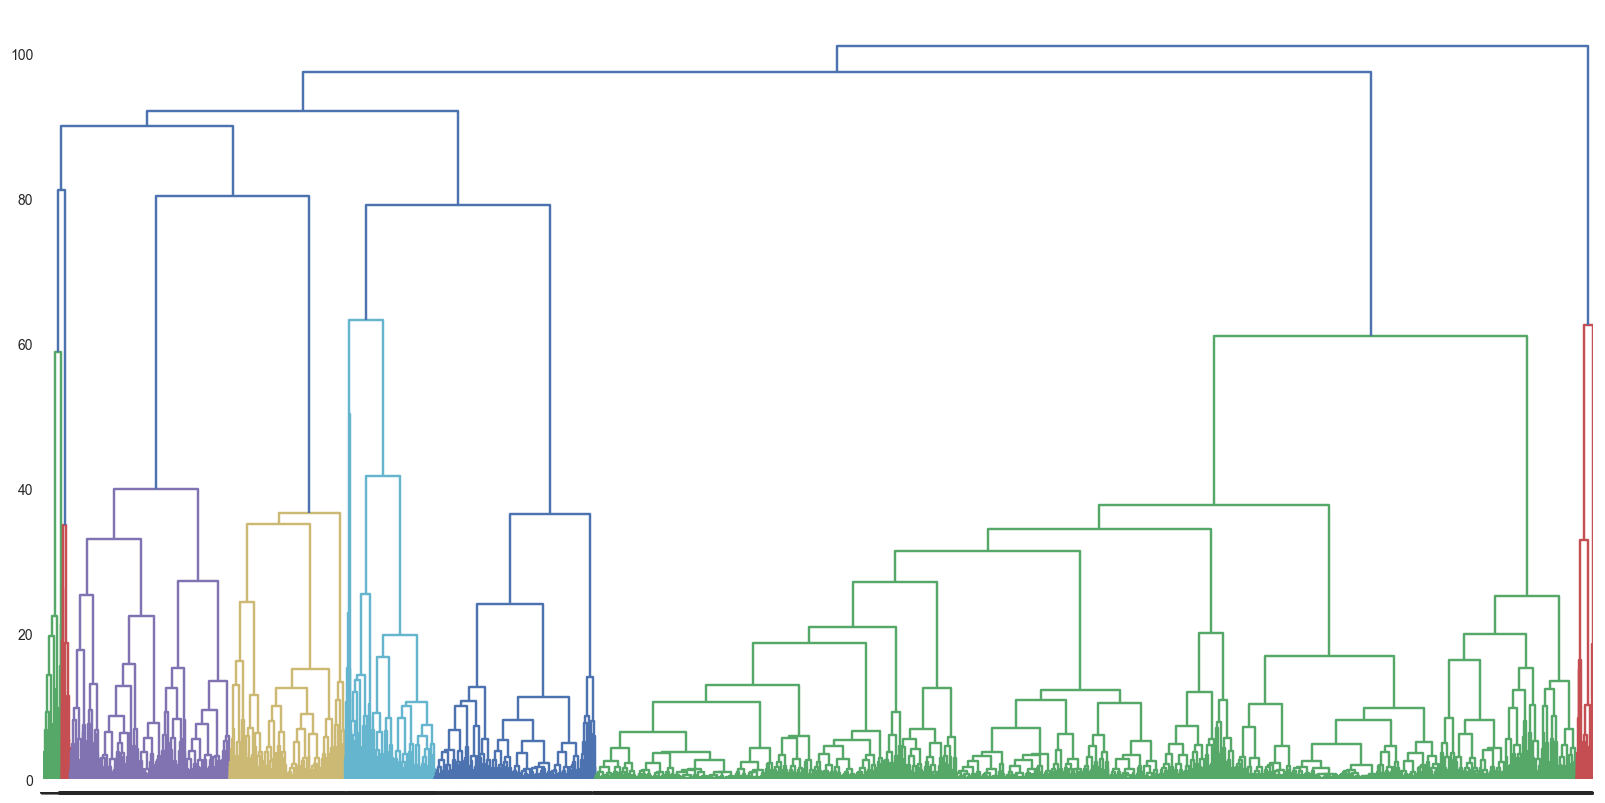

In [19]:
# расссчитаем расстояния между кластерами
linked = linkage(pC_norm, 'ward')

plt.figure(figsize=(20, 10))

# визуализируем дендрограмму с ориентацией top
# сначала будут отрисовываться кластеры с минимальным расстоянием между друг другом
dendrogram(Z=linked,
            orientation='top',
            labels=ac_preds,
            distance_sort='descending')

plt.show()

Визуализируем также результаты кластеризации k-means, отобразив два признака — количество покупок и кредитный лимит:

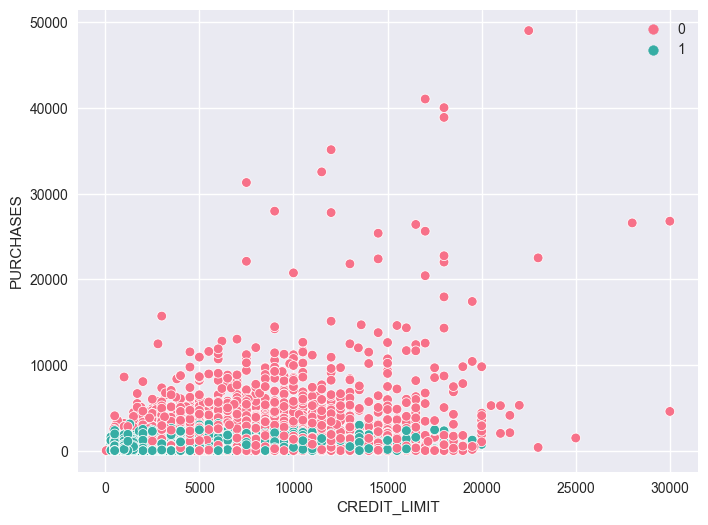

In [20]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=cc_df, x='CREDIT_LIMIT', y='PURCHASES', hue=preds_gm, palette='husl')
plt.show()

Практически все точки сконцентрированы так плотно, что причины в целом неудовлетворительных результатов кластеризации становятся чуть более понятными.

С точки зрения интерпретации на графике явно выделяется группа тех, кто совершает много покупок по кредитной карте, и тех, кто совершает их меньше и имеет меньший кредитный лимит.

Но, разумеется, это лишь приблизительная интерпретация, ведь качественного разбиения с помощью большинства методов мы так и не получили, а кроме того, здесь мы видим лишь два признака из многих, на основе которых осуществлялась кластеризация.

## Итог

Как видим, задача кластеризации клиентов банка весьма нетривиальна.

Успешность сегментации косвенно возможно определить исходя из поставленной задачи: какие общие характеристики получившихся кластеров нас более всего интересуют. Но, вероятно, часто предполагается, что модель сможет найти непредвиденные принципы разбиения данных, и тогда важным становится этап анализирования уже результатов сегментации, а это предполагает довольно объемную аналитическую работу. Впрочем, некоторая аналитическая работа должна также предварять этап моделирования кластеризации. Однако за неимением конкретного ТЗ мы в рамках настоящей работы нашли приемлемым не уделять задаче более времени, чем сумели уже истратить.